In [1]:
import os, time
import numpy as np
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from torchsummary import summary
device = "cuda"

In [2]:
from sklearn.utils import shuffle
df = pd.read_csv("./dataset/train.csv")
broken_list = []
broken_list.append(df.loc[df['ImageId'] == 'ID_1a5a10365'].index)
broken_list.append(df.loc[df['ImageId'] == 'ID_4d238ae90'].index)
broken_list.append(df.loc[df['ImageId'] == 'ID_408f58e9f'].index)
broken_list.append(df.loc[df['ImageId'] == 'ID_bb1d991f6'].index)
broken_list.append(df.loc[df['ImageId'] == 'ID_c44983aeb'].index)

for idx in broken_list:
    df = df.drop(idx)
print(len(df))
# df = shuffle(df)
df.to_csv("./dataset/train_shuf_remove.csv")


4257


# Ignore Mask cleaning

In [ ]:
def CreateMaskImages(dir_path,image_Name):
    train_image = cv2.imread("{}_images/{}.jpg".format(dir_path,image_Name))
    if not os.path.isfile("{}_masks/{}.jpg".format(dir_path,image_Name)):
        return train_image
    image_mask = cv2.imread("{}_masks/{}.jpg".format(dir_path,image_Name),0)
    image_mask = image_mask//200*255
#     image_mask = np.ceil((image_mask//255))*255
#     image_mask = np.array(image_mask,dtype=np.uint8)

#     print(np.max(image_mask),np.min(image_mask))

    image_mask_inv = cv2.bitwise_not(image_mask)
    res = cv2.bitwise_and(train_image,train_image,mask = image_mask_inv)
    #cut upper half,because it doesn't contain cars.
#     res = res[res.shape[0] // 2:]
    return res
    
train_pd = pd.read_csv("./dataset/train_shuf_remove.csv")
train_dir = "./dataset/train"
data_len = len(train_pd)

for idx in range(0,data_len):
    if idx%500==0:
        print("idx:",idx)
    file_name = train_pd['ImageId'].iloc[idx]
    res = CreateMaskImages(train_dir,file_name)
    cv2.imwrite("./dataset/masked_train/" + file_name + ".jpg", res)

    
test_pd = pd.read_csv("./dataset/sample_submission.csv")
test_dir = "./dataset/test"
data_len = len(test_pd)

for idx in range(0,data_len):
    if idx%500==0:
        print("idx:",idx)
    file_name = test_pd['ImageId'].iloc[idx]
    res = CreateMaskImages(test_dir,file_name)
    cv2.imwrite("./dataset/masked_test/" + file_name + ".jpg", res)
    

# Inference on val dataset for calculating mAp

In [ ]:
# ths = [0,-0.05,-0.1,-0.15,-0.2]
ths = [0,-1]
model = CentResnet(8)
model.cuda()
# model.load_state_dict(torch.load("./saved_model/res50_vr0.05_imgaugv2/Ep7_loss8.9245"))
model.load_state_dict(torch.load("./saved_model/res34_vr0.01/Ep5_loss8.5530"))
model.eval()
val_pd = pd.read_csv("./dataset/train_shuf_remove.csv")
vr = 0.01
print(len(val_pd))
val_pd = val_pd[int(len(val_pd)*(1-vr)):]
print(len(val_pd))

In [ ]:
for threshold in ths:
    predictions = []
    indices_len = len(val_pd)
    print("indices_len",indices_len)
#     val_dataset = ADDataset(data_len=indices_len,is_validate=True,validate_rate=vr,indices=indices)
#     val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    with torch.no_grad():
        for img,_,_ in tqdm(val_loader):
            img = img.to(device)
            output = model(img).cpu().numpy()
            for out in output:
                coords = extract_coords(out,logits_thresh=threshold)
                s = coords2str(coords)
                predictions.append(s)

    print(np.shape(predictions))
    val_pd['PredictionString']= predictions
    file_name = "val_pred_th{}.csv".format(threshold)
    val_pd.to_csv(file_name, index=False)
    val_pd.head()        

# mAP calculating

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from math import sqrt, acos, pi, sin, cos
from scipy.spatial.transform import Rotation as R
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
# from inspect import signature
import matplotlib.pyplot as plt
from multiprocessing import Pool

def expand_df(df, PredictionStringCols):
    df = df.dropna().copy()
    df['NumCars'] = [int((x.count(' ')+1)/7) for x in df['PredictionString']]

    image_id_expanded = [item for item, count in zip(df['ImageId'], df['NumCars']) for i in range(count)]
    prediction_strings_expanded = df['PredictionString'].str.split(' ',expand = True).values.reshape(-1,7).astype(float)
    prediction_strings_expanded = prediction_strings_expanded[~np.isnan(prediction_strings_expanded).all(axis=1)]
    df = pd.DataFrame(
        {
            'ImageId': image_id_expanded,
            PredictionStringCols[0]:prediction_strings_expanded[:,0],
            PredictionStringCols[1]:prediction_strings_expanded[:,1],
            PredictionStringCols[2]:prediction_strings_expanded[:,2],
            PredictionStringCols[3]:prediction_strings_expanded[:,3],
            PredictionStringCols[4]:prediction_strings_expanded[:,4],
            PredictionStringCols[5]:prediction_strings_expanded[:,5],
            PredictionStringCols[6]:prediction_strings_expanded[:,6]
        })
    return df

def str2coords(s, names):
    coords = []
    for l in np.array(s.split()).reshape([-1, 7]):
        coords.append(dict(zip(names, l.astype('float'))))
    return coords

def TranslationDistance(p,g, abs_dist = False):
    dx = p['x'] - g['x']
    dy = p['y'] - g['y']
    dz = p['z'] - g['z']
    diff0 = (g['x']**2 + g['y']**2 + g['z']**2)**0.5
    diff1 = (dx**2 + dy**2 + dz**2)**0.5
    if abs_dist:
        diff = diff1
    else:
        diff = diff1/diff0
    return diff

def RotationDistance(p, g):
    true=[ g['pitch'] ,g['yaw'] ,g['roll'] ]
    pred=[ p['pitch'] ,p['yaw'] ,p['roll'] ]
    q1 = R.from_euler('xyz', true)
    q2 = R.from_euler('xyz', pred)
    diff = R.inv(q2) * q1
    W = np.clip(diff.as_quat()[-1], -1., 1.)
    
    # in the official metrics code:
    # https://www.kaggle.com/c/pku-autonomous-driving/overview/evaluation
    #   return Object3D.RadianToDegree( Math.Acos(diff.W) )
    # this code treat θ and θ+2π differntly.
    # So this should be fixed as follows.
    W = (acos(W)*360)/pi
    if W > 180:
        W = 360 - W
    return W

def print_pr_curve(result_flg, scores, recall_total=1):
    average_precision = average_precision_score(result_flg, scores)
    precision, recall, _ = precision_recall_curve(result_flg, scores)
    recall *= recall_total
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.show()
    
    
###TP,FP calculating    
thres_tr_list = [0.1, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01]
thres_ro_list = [50, 45, 40, 35, 30, 25, 20, 15, 10, 5]
def check_match(idx,train_df,valid_df):
    keep_gt=False
    thre_tr_dist = thres_tr_list[idx]
    thre_ro_dist = thres_ro_list[idx]
    train_dict = {imgID:str2coords(s, names=['carid_or_score', 'pitch', 'yaw', 'roll', 'x', 'y', 'z']) for imgID,s in zip(train_df['ImageId'],train_df['PredictionString'])}
    valid_dict = {imgID:str2coords(s, names=['pitch', 'yaw', 'roll', 'x', 'y', 'z', 'carid_or_score']) for imgID,s in zip(valid_df['ImageId'],valid_df['PredictionString'])}
    result_flg = [] # 1 for TP, 0 for FP
    scores = []
    MAX_VAL = 10**10
    for img_id in valid_dict:
        for pcar in sorted(valid_dict[img_id], key=lambda x: -x['carid_or_score']):
            # find nearest GT
            min_tr_dist = MAX_VAL
            min_idx = -1
            for idx, gcar in enumerate(train_dict[img_id]):
                tr_dist = TranslationDistance(pcar,gcar)
                if tr_dist < min_tr_dist:
                    min_tr_dist = tr_dist
                    min_ro_dist = RotationDistance(pcar,gcar)
                    min_idx = idx
                    
            # set the result
            if min_tr_dist < thre_tr_dist and min_ro_dist < thre_ro_dist:
                if not keep_gt:
                    train_dict[img_id].pop(min_idx)
                result_flg.append(1)
            else:
                result_flg.append(0)
            scores.append(pcar['carid_or_score'])
    
    return result_flg, scores    


In [9]:
def calculate_mAp(val_file_name):
    valid_df = pd.read_csv(val_file_name)
    expanded_valid_df = expand_df(valid_df, ['pitch','yaw','roll','x','y','z','Score'])
    valid_df = valid_df.fillna('')
    train_df = pd.read_csv('./dataset/train_shuf_remove.csv')    
    train_df = train_df[train_df.ImageId.isin(valid_df.ImageId.unique())]

    # data description page says, The pose information is formatted as
    # model type, yaw, pitch, roll, x, y, z
    # but it doesn't, and it should be
    # model type, pitch, yaw, roll, x, y, z
    expanded_train_df = expand_df(train_df, ['model_type','pitch','yaw','roll','x','y','z'])

    n_gt = len(expanded_train_df)
    ap_list = []
    for i in range(10):
        result_flg, scores = check_match(i,train_df,valid_df)
        if np.sum(result_flg) > 0:
            n_tp = np.sum(result_flg)
            recall = n_tp/n_gt
            ap = average_precision_score(result_flg, scores)*recall
    #         print_pr_curve(result_flg, scores, recall)
        else:
            ap = 0
        ap_list.append(ap)
    mAp = np.mean(ap_list)
#     print('map:', map)
    return mAp

In [ ]:
val_root = './tmp_val_files_res34'
for file_name in os.listdir(val_root):
    if file_name.find('val')==-1:
        continue
    mAp = calculate_mAp("{}/{}".format(val_root,file_name))
    print("File:{}, mAp:{}".format(file_name,mAp))
    
# File:val_pred_th-0.05.csv, mAp:0.08649828065365775
# File:val_pred_th-0.1.csv, mAp:0.08747285847558277
# File:val_pred_th-0.15.csv, mAp:0.08800964404151594
# File:val_pred_th-0.2.csv, mAp:0.0892720989062064
# File:val_pred_th-0.25.csv, mAp:0.090172810018739
# File:val_pred_th-0.3.csv, mAp:0.09107042738930553
# File:val_pred_th-1.csv, mAp:0.0996630598935023
# File:val_pred_th0.csv, mAp:0.08567564132050562    

# Visualize image

In [ ]:
global_data = pd.read_csv("./dataset/critic01_20k.csv")

In [ ]:
for idx in range(0,100):

    i = idx
    img = global_data.iloc[i, 1:].values.astype(np.uint8).reshape((28, 28))  #value: 0~255
    img = Image.fromarray(img)
    label = global_data.iloc[i, 0]
    
    if i%10==0:
        plt.pause(.1)
        fig, axes = plt.subplots(1,10,figsize=(16,2))
    axes[i%10].imshow(img,cmap="gray")
    
    #     img = trans(img).cpu().numpy().reshape(28,28)
    #     img = transforms.functional.adjust_brightness(img, 0.01)
    #     img = transforms.functional.adjust_contrast(img, 0.01)
    #     img = transforms.functional.adjust_saturation(img, 5)
#         axes[j][1].imshow(img,cmap="gray")
    
#     img = global_data_dig.iloc[i, 1:].values.astype(np.uint8).reshape((28, 28))  #value: 0~255
#     img = Image.fromarray(img)
#     label = global_data_dig.iloc[i, 0]
#     axes[2].imshow(img,cmap="gray")
#     img = trans(img).cpu().numpy().reshape(28,28)
#     axes[3].imshow(img,cmap="gray")
    

    print("Label:",label)

# data.head(5)

              precision    recall  f1-score   support

         0.0     0.9284    0.8232    0.8727      1024
         1.0     0.9289    0.9180    0.9234      1024
         2.0     0.8619    0.9814    0.9178      1024
         3.0     0.9672    0.8359    0.8968      1024
         4.0     0.9714    0.9619    0.9666      1024
         5.0     0.9685    0.9619    0.9652      1024
         6.0     0.7804    0.8848    0.8293      1024
         7.0     0.8542    0.8184    0.8359      1024
         8.0     0.9722    0.9580    0.9651      1024
         9.0     0.8758    0.9297    0.9019      1024

    accuracy                         0.9073     10240
   macro avg     0.9109    0.9073    0.9075     10240
weighted avg     0.9109    0.9073    0.9075     10240



Text(0.5, 69.0, 'Predicted label')

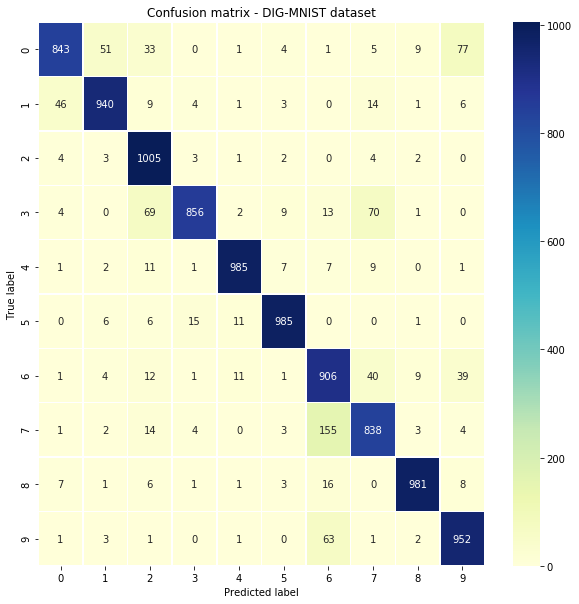

In [171]:
import seaborn as sn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

###Confusion matrix
print(classification_report(labels, result,digits=4))
plt.figure(figsize=(10,10))
confusion_mat = confusion_matrix(labels, result)
sn.heatmap(confusion_mat, annot=True, cmap='YlGnBu',fmt="d",linewidths=.5, linecolor='w')
plt.title('Confusion matrix - DIG-MNIST dataset')
plt.ylabel('True label')
plt.xlabel('Predicted label')


In [ ]:
# indices1 = np.where(result!=labels)[0]       #(num)
# indices2 = np.where(result_dig!=labels)[0]
# indices3 = np.where((result!=labels)&(result_dig==labels))[0]
indices4 = np.where((result[:,0]==labels))[0]
indices5 = np.where((result[:,0]==labels)|(result[:,1]==labels))[0]
indices6 = np.where((result[:,0]==labels)|(result[:,1]==labels)|(result[:,2]==labels))[0]

cirtic_idx_list_ans0 = []
idx_list_ans1 = []

cirtic_idx_list_ans9 = []
label_list = []
count = 0

data_num = len(labels)
print("top1 acc:",len(indices4)/data_num)
print("top2 acc:",len(indices5)/data_num)
print("top3 acc:",len(indices6)/data_num)
stop

for i in range(0,len(indices1)):
    idx = indices1[i]
#     img1 = global_dig.iloc[idx, 1:].values.astype(np.uint8).reshape((28, 28))  #value: 0~255
#     img1 = global_pseudo_data.iloc[idx, 1:].values.astype(np.uint8).reshape((28, 28))  #value: 0~255
    img1 = global_data.iloc[idx, 1:].values.astype(np.uint8).reshape((28, 28))  #value: 0~255
    img1 = Image.fromarray(img1)
    label1 = result[idx]
#     label2 = result_dig[idx]
    label2 = None
    label = labels[idx]
  

#     if label == 0:
#         fig, axes = plt.subplots(1,1,figsize=(2,2))
# #         cirtic_idx_list_ans0.append(idx)
#         axes.imshow(img1,cmap="gray")
#         print(idx)
#         print("Model:",label1," Model2:",label2," Label:",label)
#         plt.pause(.1)
#     else:
#         continue
        

# print(idx_list_ans1)
# np.save("idx_ans1",idx_list_ans1)

# print(cirtic_idx_list_ans0)
# print(cirtic_idx_list_ans9)

cirtic_idx_list_ans0_v2 = [5520,6150,12280,18560,32730]
np.save("critic_idx_ans0_v2",cirtic_idx_list_ans0_v2)

# plt.figure(figsize=(8,4))
# data = np.uint8(cirtic_label_list)
# print(len(data))
# plt.hist(data ,density=0,align="mid",bins=10,rwidth=1)
# plt.xticks(range(10))
# plt.ylabel('frequency')

# plt.figure(figsize=(8,4))
# data = np.uint8(label_list)
# print(len(data))
# plt.hist(data ,density=0,align="mid",bins=10,rwidth=1)
# plt.xticks(range(10))
# plt.ylabel('frequency')


# 31 1 0 59969